In [1]:
# Created by Tariq Anwar Aquib,2024, KAUST
# tariqanwar.aquib@kaust.edu.sa

%reset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload

import get_slip_and_hyp
import get_Vr_PSV
import Calibrate_KinParams
import Compute_Yoffe_and_ML_STF
import plot_mtf_rate

reload(get_slip_and_hyp)
reload(get_Vr_PSV)
reload(Calibrate_KinParams)
reload(Compute_Yoffe_and_ML_STF)
reload(plot_mtf_rate)

from get_slip_and_hyp import *
from get_Vr_PSV import *
from Calibrate_KinParams import *
from Compute_Yoffe_and_ML_STF import *
from plot_mtf_rate import *


In [2]:
# Input parameters for MLRG

W = 14; L = 20.8; Mw = 6.5       # Width, Length and Magnitude
mech = 'ss'; rake = 0          # Mechanism                            
acf = 'ak'                      # ACF
corr = np.array([5, 5, 0.77])   # Correlation lengths for slip [az, ax, H]
seed = []; #np.array([2])                       # Seed for slip
samp = np.array([0.2,0.2])      # Sampling in km

taper_width=[1,1,1]             # Taper width in km  [left/right, top bottom]
taper_window = 'hn'

Vr_mean = 2.25                  # Mean rupture velocity
SP_ratio = 2                    # Ratio of Max slip and Max Vmax on the fault; See Aquib et al., (2024)

In [3]:
### Slip and hypocenter location

slip, slip_taper, hypo_x, hypo_z, hyp_prob = get_slip_and_hyp(Mw,mech,[W,L],corr,samp,acf,seed,taper_width,taper_window)


lx = np.linspace(0,L,slip.shape[1])
lz = np.linspace(0,W,slip.shape[0])

#### If any other hypocenter is desired then specify here below:::
# hypo_x is from left end and hypo_z is from top.

# hypo_x = 25 # uncomment to specify a different hypocenter
# hypo_z = 5





In [4]:
#### Computing other kinematic rupture parameters....


vr, psv, X2, Y2, crack_length = get_Vr_PSV(slip,hypo_x,hypo_z,lx,lz,samp,rake)

vr = vr.numpy()
psv = psv.numpy()

hyp_ind_x = np.where(lx==hypo_x)[0]
hyp_ind_z = np.where(lz==hypo_z)[0]

hyp_nd = np.array([hyp_ind_z[0], hyp_ind_x[0]])



cuda


/home/aquibt/Miscellaneous/MLRG-python/models.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_model))
/home/aquibt/Miscellaneous/

In [5]:
### Calibrating Vr
vr_new = Calibrate_Vr(vr,Vr_mean,0,6)

## Computing T_onset using raytracing

t_onset = compute_onset_times_scikit(vr_new,hyp_nd,samp[0])

# Calibrating Vmax
psv_ratio_new = Calibrate_Vmax_ratio(slip,psv,SP_ratio) # Give slip in cm

psv1 = (slip_taper/100)/psv_ratio_new
a_psv = 0.01; b_psv = np.max(psv)

psv2 = Calibrate_Vmax(psv1,a_psv,b_psv)

# Computing Tr
Tacc_ratio = 0.1
Tr_eff = Compute_Tr(psv2,slip_taper/100,Tacc_ratio=Tacc_ratio)
Tacc = Tr_eff*Tacc_ratio

# Computing STFs and modified STFs based on ML
# slip_rate_ml0 is without Andrews (2005) condition
# slip_rate_ml1 is with Andrews (2005) condition

slip_time, slip_rate_yoffe, slip_rate_ml0, slip_rate_ml1, Tr_new0, Vmax_new0, Tr_new1, Vmax_new1 = Compute_Yoffe_and_ML_STF(slip_taper/100,vr,X2,Y2,crack_length,t_onset,Tr_eff,Tacc_ratio,t_end=20,num_pts=501)



/home/aquibt/Miscellaneous/MLRG-python/Compute_Yoffe_and_ML_STF.py:28: RuntimeWarning: invalid value encountered in divide
  slip_rate_norm[i,j,:] = slip_rate[i,j,:]/np.max(np.abs((slip_rate[i,j,:]))) # Can divide by NaN when Yoffe not possible (for very small slip values; neglect them)


Yoffe STFs computed


/home/aquibt/Miscellaneous/MLRG-python/models_STF.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_model).cuda()
/home/aquibt/Miscellaneous/MLRG

First ML STFs computed
Modifying 1 STFs out of 7455


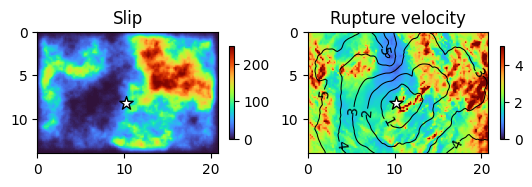

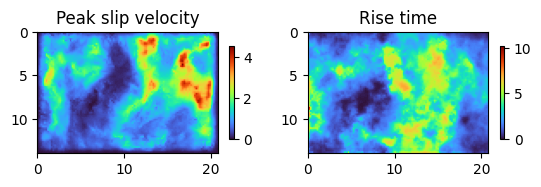

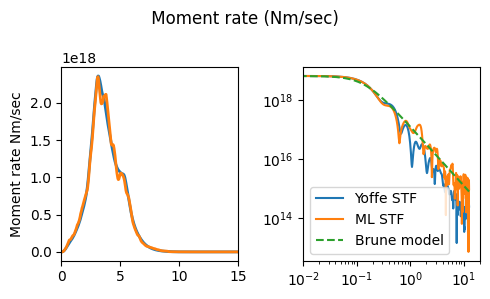

In [6]:
## Plot kinematic parameters without Andrews (2005) condition

graph1, (plot1, plot2) = plt.subplots(1, 2)

ax = plot1.imshow(np.flipud(slip_taper),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(slip_taper)))
levels = np.array([0,1,2,3,4,5,6,7,8])
plot1.set_title('Slip')
plot1.scatter(hypo_x,hypo_z,100,c='w',marker='*',edgecolors='k')
plot1.yaxis.set_inverted(True)

graph1.colorbar(ax,shrink=0.25) 

ax= plot2.imshow(np.flipud(vr_new),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,5))
plot2.yaxis.set_inverted(True)
plot2.scatter(hypo_x,hypo_z,100,c='w',marker='*',edgecolors='k')
CS = plot2.contour(lx,lz,t_onset, levels,colors=['black'],linewidths=0.75)
plot2.clabel(CS)
plot2.set_title('Rupture velocity')
graph1.colorbar(ax,shrink=0.25)

# Tr and PSV

graph1, (plot1, plot2) = plt.subplots(1, 2)

ax = plot1.imshow(np.flipud(Vmax_new0),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(Vmax_new0)))
plot1.set_title('Peak slip velocity')
graph1.colorbar(ax,shrink=0.25) 
plot1.yaxis.set_inverted(True)

ax = plot2.imshow(np.flipud(Tr_new0),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(Tr_new0)))
plot2.set_title('Rise time')
graph1.colorbar(ax,shrink=0.25) 
plot2.yaxis.set_inverted(True)

## MTF and spectra

plot_mtf_rate(slip_time,slip_rate_yoffe,slip_rate_ml0,samp)



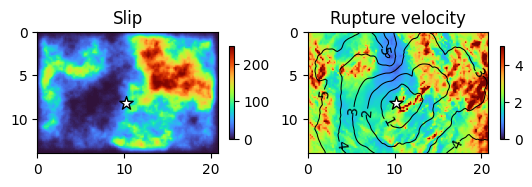

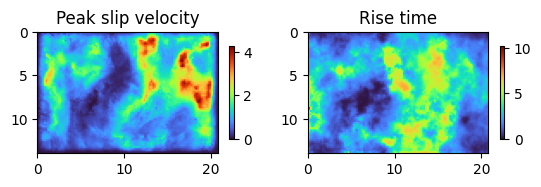

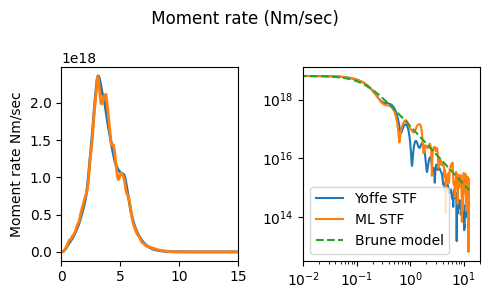

In [7]:
## Plot kinematic parameters with Andrews (2005) condition; IF no STFs are modified then it similar to previous figure;

graph1, (plot1, plot2) = plt.subplots(1, 2)

ax = plot1.imshow(np.flipud(slip_taper),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(slip_taper)))
levels = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plot1.set_title('Slip')
plot1.scatter(hypo_x,hypo_z,100,c='w',marker='*',edgecolors='k')
plot1.yaxis.set_inverted(True)

graph1.colorbar(ax,shrink=0.25) 

ax= plot2.imshow(np.flipud(vr_new),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,5))
plot2.yaxis.set_inverted(True)
plot2.scatter(hypo_x,hypo_z,100,c='w',marker='*',edgecolors='k')
CS = plot2.contour(lx,lz,t_onset, levels,colors=['black'],linewidths=0.75)
plot2.clabel(CS)
plot2.set_title('Rupture velocity')
graph1.colorbar(ax,shrink=0.25)

# Tr and PSV

graph1, (plot1, plot2) = plt.subplots(1, 2)

ax = plot1.imshow(np.flipud(Vmax_new1),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(Vmax_new1)))
plot1.set_title('Peak slip velocity')
graph1.colorbar(ax,shrink=0.25) 
plot1.yaxis.set_inverted(True)

ax = plot2.imshow(np.flipud(Tr_new1),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(Tr_new0)))
plot2.set_title('Rise time')
graph1.colorbar(ax,shrink=0.25) 
plot2.yaxis.set_inverted(True)

## MTF and spectra

plot_mtf_rate(slip_time,slip_rate_yoffe,slip_rate_ml1,samp)



In [8]:
### save this 

# params = { 'slip_ml':slip, 'slip':slip_taper,  'vr':vr, 'vr_new':vr_new , 't_onset1':t_onset, 'hyp_ind':hyp_nd, 'psv': psv, 'psv2': psv2, 'Tr':Tr_eff,'slip_rate':slip_rate,
#           'slip_rate_norm':slip_rate_norm, 'stf2':stf2, 'X':X2, 'Y':Y2, 'crack_length':crack_length, 'meta_data':meta_data}

# scipy.io.savemat('./kin_field.mat', {'params':params})